In [1]:
import torch
from torch import nn

In [2]:
# only for the subtract function which we're using for tensor functionality on torch.Size objects
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Q1

In [4]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=1,
                 kernel_size=(1, 1), stride=1, padding=0):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        if stride < 0:
            raise RuntimeError('stride cannot be a negative value!')
        if padding < 0:
            raise RuntimeError('padding cannot be a negative value!')

        self.stride = stride
        self.padding = padding

        self.kernel = nn.Parameter(
            torch.rand((out_channels, in_channels, *kernel_size))
        )
        # number of parameters for the bias tensor is the number of output channels
        self.bias = nn.Parameter(torch.rand((out_channels, )))
        # initializaing p,q kernel window sizes for simplicity
        self.p, self.q = kernel_size

    def forward(self, X):
        vertical_padding = torch.zeros((*(X.shape[:-1]), self.padding))
        # padding vertically and then padding horizontally. creating a list as it's mutable
        horizontal_padding_shape = list((*(X.shape[:-1]), X.shape[-1] + 2 * self.padding))
        # changing the relevant axis for padding to the padding size
        horizontal_padding_shape[2] = self.padding
        horizontal_padding_shape = tuple(horizontal_padding_shape)
        # creating the padding tensor
        horizontal_padding = torch.zeros(horizontal_padding_shape)
        # padding vertically, dim 3 is the columns of the pixels in each channel
        X = torch.cat((vertical_padding, torch.cat((X, vertical_padding), dim=3)), dim=3)
        # padding horizontally, dim 2 is the rows of the pixels in each channel
        X = torch.cat((horizontal_padding, torch.cat((X, horizontal_padding), dim=2)), dim=2)

        # expected X shape = (batch_size, n_channels, img_rows+2*padding, img_cols+2*padding)

        # getting the shape of the sub tensors
        view_shape = tuple(np.subtract(X.shape, self.kernel.shape) + 1) + self.kernel.shape
        # getting the strides for which we want to iterate in the batch
        strides = X.stride() + X.stride()
        # getting all sub tensors with the defined kernel shape
        sub_matrices_of_kernel_size = torch.as_strided(X, view_shape, strides)
        # getting all sub tensors of kernel size with the stride
        sub_matrices_of_kernel_size_strided = sub_matrices_of_kernel_size[:, :, ::self.stride, ::self.stride, ...]
        # getting the convolution
        convoluted_X = (sub_matrices_of_kernel_size_strided * self.kernel).sum(
            # first 4 dimensions of the are batch_size, number of channels, and image channels' shape
            dim=(tuple(range(4, 7+1)))
        )
        # incrementing each channel by the bias
        convoluted_X += self.bias

        return convoluted_X

In [5]:
import torchvision
from torch.utils.data import DataLoader

In [6]:
train_data_transformed = torchvision.datasets.FashionMNIST(root='./fashion_mnist',
                                                           train=True,
                                                           download=True,
                                                           transform=torchvision.transforms.PILToTensor())

train_dataloader = DataLoader(train_data_transformed, batch_size=64)

In [7]:
for batch_idx, (batch_X, batch_y) in enumerate(train_dataloader):
    imgs = batch_X
    break

In [8]:
imgs.shape

torch.Size([64, 1, 28, 28])

In [9]:
custom_conv_layer = CustomConv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=2, padding=2)

In [10]:
custom_conv_layer(imgs).shape

torch.Size([64, 1, 15, 15])

In [11]:
import torchvision.transforms as T

In [12]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3), stride=2, padding=2)
conv_layer(imgs.to(torch.float32)).shape

torch.Size([64, 1, 15, 15])

### Q2

### Q3

In [13]:
cifar10_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=True,
                                              download=True,
                                              transform=T.PILToTensor())

Files already downloaded and verified


In [14]:
cifar10_dataloader = DataLoader(cifar10_dataset, batch_size=64)

In [15]:
for batch_idx, (batch_X, batch_y) in enumerate(cifar10_dataloader):
    imgs = batch_X
    break

In [16]:
imgs.shape

torch.Size([64, 3, 32, 32])

In [17]:
import matplotlib.pyplot as plt

In [18]:
img = next(iter(cifar10_dataloader))

In [19]:
img[0].shape, img[1]

(torch.Size([64, 3, 32, 32]),
 tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
         2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
         2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2]))

In [20]:
targets = np.array(cifar10_dataset.targets)

In [21]:
type(targets)

numpy.ndarray

#### Plotting image from every class

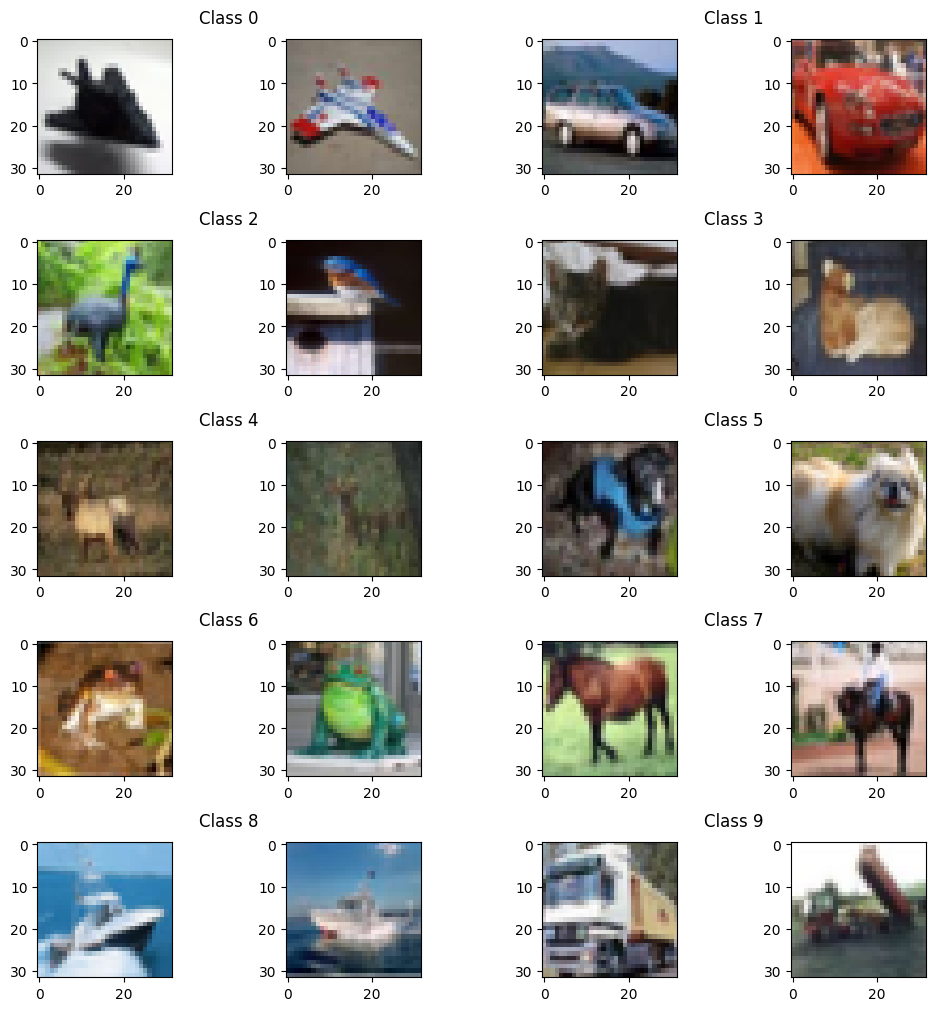

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
# creating the subfigures
subfigs = fig.subfigures(5, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {class_idx}')
    # getting the subfigure axes and plotting
    axes = subfig.subplots(1, 2)
    axes[0].imshow(cifar10_dataset.data[np.where(targets == class_idx)][0])
    axes[1].imshow(cifar10_dataset.data[np.where(targets == class_idx)][1])

#### Importing the ResNet18 pretrained model

In [23]:
import torchvision.models as models

In [24]:
resnet18 = models.resnet18(pretrained=True)

/home/zivlazarov/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zivlazarov/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
for name, layer in resnet18.named_modules():
    print(f'{name}: {layer}')

: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


#### Changing the output layer to match the CIFAR10 dataset we imported

In [26]:
resnet18._modules['fc'] = nn.Linear(in_features=512, out_features=10, bias=True)

In [27]:
resnet_transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda t: t.to(dtype=torch.float, device=device)),
    # standardizing the values to match the training values range
    T.Lambda(lambda t: t/255.0),
    # T.Lambda(lambda t: torch.movedim(t, 2, 0)),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])),
    # T.Lambda(lambda tensor: tensor.to(device))
])

In [28]:
type(cifar10_dataset.targets)

list

In [29]:
cifar10_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=True,
                                              download=False,
                                              transform=resnet_transform,
                                               target_transform=T.Compose([
                                                   T.Lambda(lambda tensor:
                                                            torch.tensor(tensor).to(device=device))
                                               ]))

cifar10_dataloader = DataLoader(cifar10_dataset, batch_size=256)
cifar10_dataloader_full = DataLoader(cifar10_dataset, batch_size=len(cifar10_dataset.data))

In [30]:
list(resnet18.modules())[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=10, bias=True)]

In [31]:
parameters = [param for name, param in resnet18.named_parameters() if name.startswith('fc')]

In [32]:
for name, param in resnet18.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

In [33]:
optimizer = torch.optim.SGD(parameters, lr=0.001, momentum=0.99)

In [34]:
loss = nn.CrossEntropyLoss()

In [35]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
epochs = 5

train_loss, train_accuracy = torch.zeros(epochs).to(device), torch.zeros(epochs).to(device)

In [37]:
from tqdm import tqdm

In [38]:
@torch.no_grad
def evaluate_epoch(epoch_num, epoch_loss_values, epoch_num_correct_preds, dataset_size):
    epoch_accuracy = epoch_num_correct_preds / dataset_size
    epoch_loss = epoch_loss_values
    return epoch_loss, epoch_accuracy

In [41]:
@torch.no_grad
def evaluate_batch(epoch_num, batch_idx, model, loss_func, batch_X, batch_y):
    model.eval()

    batch_predictions = torch.argmax(model(batch_X), dim=1).to(dtype=torch.float, device=device)
    loss_value = loss_func(batch_predictions, batch_y.to(torch.float))
    num_correct_preds = (batch_predictions == batch_y).sum()
    return loss_value, num_correct_preds

In [ ]:
dataset_size = len(cifar10_dataset)
epoch_loss = 0
epoch_accuracy = 0

for epoch in tqdm(range(epochs)):
    resnet18.train()
    for batch_idx, (batch_X, batch_y) in enumerate(cifar10_dataloader):
        optimizer.zero_grad()
        batch_output = resnet18(batch_X)
        batch_loss = loss(batch_output, batch_y)
        batch_loss.backward()
        optimizer.step()

        batch_loss, batch_accuracy = evaluate_batch(epoch, batch_idx, resnet18, loss, batch_X, batch_y)
        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy

    train_loss[epoch], train_accuracy[epoch] = evaluate_epoch(epoch, epoch_loss, epoch_accuracy, dataset_size)

    epoch_loss = 0
    epoch_accuracy = 0

 20%|███████████████████████████████████▍                                                                                                                                             | 1/5 [05:46<23:05, 346.46s/it]

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(train_accuracy.to('cpu').detach().numpy(), label='Accuracy')
axes[0].set_title('Accuracy')
axes[1].plot(train_loss.to('cpu').detach().numpy(), label='Loss')
axes[1].set_title('Loss')

In [ ]:
!nvidia-smi

In [ ]:
torch.cuda.empty_cache()